# Age of Empires 2 Player Model

This model is used to rank invidividual players in team games. This model will allow us to better balance teams by calculating the probability that team wins before we actually play.

## Todo:
- Load data from Google Sheet instead of local CSV
- Determine what EDA should be done
- Determine where there should be an intercept term in the logistic regression
- Fix GridSearchCV to LogisticRegression import
- Explore adding a time component to factor in player improvement
- Determine how to better input data for predicting
- Build other classifiers

## Import dependencies

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np

## Import Data

In [2]:
df = pd.read_csv("sample_data.csv")

# Designate all columns that are not `Outcome` as features and `Outcome` as target
X = df.loc[:, df.columns != 'Outcome']
y = df.Outcome

df.head(2)

,Shaq,Gray,Rushi,Marc,Peter,Pat,Sam,Ori,Vic,Ardy,Chad,Pat_Jr,Pat_Jr_Jr,Matt_M,Ben,Mikey,Evan,Medium_AI,Extra_Team,Outcome
0,1,0,-1,-1,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,-1,-1
1,1,0,-1,0,-1,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,-1


## Explore Data
This is where I should explore data. I haven't done any EDA since I created this dataset.

## Split data
I will split the data into a training set and validation set. The validation set is for checking the accuracy of the best tuned model that results from cross-validation. I will hold out 20% for validation.

In [3]:
X_train,X_validate,y_train,y_validate=train_test_split(X,y,test_size=0.33,random_state=0)

## Cross Validation
We will use cross validation and GridSearch to determine the optimal hyper parameters for the logistic regression. The parameters we will test are maximum iterations, C (regularization),  penalty function, and solver optimization. Further insight is needed on whether the regression should have an intercept term. We will assume NO intercept term.

In [4]:
max_iter=[100,110,120,130,140]
C = [0.01, 0.1, 1, 10, 100, 1000]
penalty = ['l1','l2']
solver = ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
fit_intercept=[False]
param_grid = dict(max_iter=max_iter,C=C, penalty=penalty, fit_intercept=fit_intercept, solver=solver)

We will now execute the GridSearch over three folds. We will use `accuracy` to assess the performance of the hyperparameters.

In [5]:
lr = LogisticRegression()
grid = GridSearchCV(estimator=lr, param_grid=param_grid, cv = 3, n_jobs=-1, scoring='accuracy')
best_model = grid.fit(X_train, y_train)

print("Best score: {0} using {1}".format(round(best_model.best_score_,2), best_model.best_params_))

Best score: 0.62 using {'C': 100, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Assess performance
We will now use the tuned hyperparameters to ensure accuracy on the validation set. As a reminder, The model is trained on the training set and the scores are computed on the validation set.

In [6]:
y_true, y_pred = y_validate, best_model.predict(X_validate)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.50      0.62        10
           1       0.74      0.93      0.82        15

    accuracy                           0.76        25
   macro avg       0.79      0.72      0.72        25
weighted avg       0.78      0.76      0.74        25



We can also use a ROC curve to visualize performance. The more above the diagonal, the better. More info [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

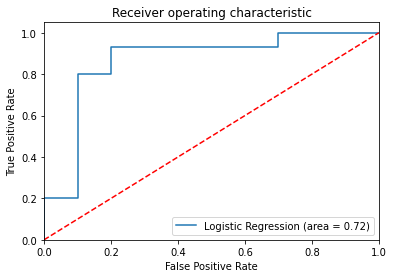

In [7]:
logit_roc_auc = roc_auc_score(y_validate, best_model.predict(X_validate))
fpr, tpr, thresholds = roc_curve(y_validate, best_model.predict_proba(X_validate)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Create final model
Since we are happy with the performance of our model on the validation set, we will re-fit it with all the data. There is no concern of overfitting because we already validated against data the model hadn't seen. 

In [8]:
# TODO: must be a cleaner way to import GridSearchCV into LogisticRegression
final_model = LogisticRegression(penalty=best_model.best_params_['penalty'], 
                                 C=best_model.best_params_['C'],
                                 fit_intercept=best_model.best_params_['fit_intercept'],
                                 max_iter=best_model.best_params_['max_iter'],
                                 solver=best_model.best_params_['solver'])

final_model = final_model.fit(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


We will output the final coefficients to see how players are ranked and with what magnitude. We need to do some busy work to output a list of coefficients.

In [9]:
features = list(df.columns)
features.remove("Outcome")
[coef] = final_model.coef_.tolist()

rounded_coef = []
for number in coef:
    rounded_number = round(number, 2)
    rounded_coef.append(rounded_number)

x = zip(rounded_coef, features)
print(sorted(list(x)))

[(-4.43, 'Mikey'), (-3.68, 'Chad'), (-3.41, 'Matt_M'), (-3.19, 'Sam'), (-2.3, 'Ori'), (-2.22, 'Marc'), (-1.47, 'Evan'), (-0.94, 'Ben'), (0.26, 'Pat_Jr_Jr'), (1.27, 'Pat'), (1.35, 'Ardy'), (1.6, 'Pat_Jr'), (1.79, 'Medium_AI'), (1.88, 'Peter'), (2.09, 'Shaq'), (3.87, 'Gray'), (3.95, 'Extra_Team'), (5.25, 'Vic'), (6.06, 'Rushi')]


## Predictions
Ultimately, we want to use this model to determine the probability of a game. Each value in the array corresponds to a person. For example, the first number is Shaq, the second number is Gray, etc.

Here we have modeled the probability that Marc (-1) beats Rushi (1).

In [10]:
result = final_model.predict_proba([[0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

print("The probability that Marc beats Rushi is {0}%".format(round(result[0][0]*100,2)))

The probability that Marc beats Rushi is 0.03%


Here we have modeled the probability that Shaq (-1) beats Gray (1).

In [11]:
result = final_model.predict_proba([[-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

print("The probability that Shaq beats Gray is {0}%".format(round(result[0][0]*100,2)))

The probability that Shaq beats Gray is 14.4%


Here we have modeled the probaility that Shaq (-1) and Gray (-1) beat Rushi

In [12]:
result = final_model.predict_proba([[-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1]])

print("The probability that Shaq and Gray beat Rushi is {0}%".format(round(result[0][0]*100,2)))

The probability that Shaq and Gray beat Rushi is 97.91%


Here we have modeled the probaility that Marc (-1) beats Sam (1)

In [13]:
result = final_model.predict_proba([[0,0,0,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]])

print("The probability that Marc beats Sam is {0}%".format(round(result[0][0]*100,2)))

The probability that Marc beats Sam is 72.54%


Here we have modeled the probaility that Marc (-1) and Sam (-1) beat Rushi (1)

In [14]:
result = final_model.predict_proba([[0,0,1,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,-1]])

print("The probability that Marc and Sam beat Rushi is {0}%".format(round(result[0][0]*100,2)))

The probability that Marc and Sam beat Rushi is 0.05%


Here we have modeled the probaility that Vic (-1) beats Rushi (1)

In [15]:
result = final_model.predict_proba([[0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0]])

print("The probability that Vic beats Rushi is {0}%".format(round(result[0][0]*100,2)))

The probability that Vic beats Rushi is 30.75%
